In [2]:
# Import phase if every import is here it is to allow you to run this cell and know if you have any issue and not after a few hours of training

import tensorflow
from tensorflow import keras
import os
import numpy as np
import librosa

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Activation, Flatten, MaxPooling1D, BatchNormalization, LSTM, GaussianNoise
from tensorflow.keras.models import Sequential


from src.VoiceModule import VoiceModule
from src.classifiers.KerasClassifier import KerasClassifier
from prepare_data_utils import load_wav, preprare_wav


In [3]:
# print environment
folder_path = "../../data"
for l in os.listdir(folder_path):
    print(l)

bdes.zip
fearful
savee
calm
happy
surprised
angry
sad
keywords


In [4]:
# Transform data method

def mfcc(buffer, samplerate, dim):
    a = librosa.feature.mfcc(y=buffer, sr=samplerate, n_mfcc=dim)
    a = np.transpose(a)
    return a


In [5]:
# Create callback to later draw some graphs

class PerformanceLogger(Callback):
    def __init__(self):
        # List of tuple (loss, accuracy)
        self.training = []
        self.testing = []
    def on_epoch_end(self, epoch, logs=None):
        self.training.append((logs["loss"], logs["acc"]))
        self.testing.append((logs["val_loss"], logs["val_acc"]))

In [6]:
# This function prints metrics about a model
def print_metrics(X, Y, label_name_list):
    Y_pred = vm.model._model.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_max = np.argmax(Y, axis=1)
    print(confusion_matrix(Y_max, Y_pred))
    print(classification_report(Y_max, Y_pred, target_names=label_name_list))


In [24]:
# Create class
class EmotionClassifierLstm(KerasClassifier):
    def __init__(self, file_path=None):
        super().__init__(file_path)

    def predict(self, x):
        x = np.expand_dims(np.array([x]), axis=2)
        return self._model.predict(x)

    def build(self):
        model = Sequential()
        # This first layer add noises to the input data and serve as a data augmentation technique
        # Used to prevent overfitting of the LSTM layer and try to extract more significant feature
        model.add(GaussianNoise(0.4))
        # This layer normalise the data to speed up the training and prevent the gradient of the LSTM to explode
        # and reach exponential weight value
        model.add(BatchNormalization())
        # This is THE feature extraction layer
        model.add(LSTM(64, input_shape=(35, 13)))
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(BatchNormalization())
        # This is the second part of the network, this one will be fine tuned later
        model.add(GaussianNoise(0.2))

        # The two last layers will be fine-tuned at the end of this notebook
        model.add(Dense(32))
        model.add(Dense(6))
        model.add(Activation('softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self._model = model
        
    def train(self, X, Y, batch_size=32, epoch=720, validation_data=None, callbacks=[]):
        self._model.fit(X, Y, batch_size=batch_size, epochs=epoch, validation_data=validation_data, callbacks=callbacks)

    def transform(self, x, samplerate):
        to_process = mfcc(x, samplerate, 13)
        to_process = pad_sequences([to_process], maxlen=35, padding='post')[0]
        return to_process


In [25]:
#Instanciate model
emotion_list = ["calm", "happy", "angry", "fearful", "surprised", "sad"]
dimension_mfcc = 13
samplerate = 16000
nb_break=None
sample_duration=1
step=0.5

logger = PerformanceLogger()

cls = EmotionClassifierLstm()
vm = VoiceModule("emotion-1s", emotion_list, cls)

In [11]:
# Prepare data for training
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X, Y = preprare_wav(data, vm, sample_duration, step)
print("Done")

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad
Done


In [28]:
X_file = f"x_{'_'.join(emotion_list)}-{vm._name}.npy"
Y_file = f"y_{'_'.join(emotion_list)}-{vm._name}.npy"

In [29]:
# Saving the prepared input data 
np.save(X_file, X)
np.save(Y_file, Y)


In [10]:
# Load data for training
X, Y = np.load(X_file), np.load(Y_file)

In [15]:
"""train_size = 80 * len(X) // 100
test_size = 20 * len(X) // 100
#X = np.expand_dims(X, axis=3)
X_train, X_test, = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]"""
X = X.astype('float32')
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

print(X[0].shape)
print( X.dtype)

5435 1359
(35, 13)
float32


In [16]:
vm.model.train(X_train, Y_train, batch_size=64, epoch=100, validation_data=(X_test, Y_test), callbacks=[logger])

Train on 5435 samples, validate on 1359 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
5435/5435 [==============================] - 7s 1ms/sample - loss: 1.7081 - acc: 0.3043 - val_loss: 1.7382 - val_acc: 0.2884
Epoch 2/100
5435/5435 [==============================] - 5s 840us/sample - loss: 1.5145 - acc: 0.3875 - val_loss: 1.6854 - val_acc: 0.3208
Epoch 3/100
5435/5435 [==============================] - 6s 1ms/sample - loss: 1.4152 - acc: 0.4243 - val_loss: 1.5930 - val_acc: 0.3517
Epoch 4/100
5435/5435 [==============================] - 7s 1ms/sample - loss: 1.3549 - acc: 0.4517 - val_loss: 1.4682 - val_acc: 0.4032
Epoch 5/100
5435/5435 [==============================] - 5s 1ms/sample - loss: 1.2920 - acc: 0.4780 - val_loss: 1.3662 - val_acc: 0.4341
Epoch 6/100
5435/5435 [==============================] - 5s 950us/sample - loss: 1.2392 - acc: 0.5058 - val_loss: 1.3112 - val_acc: 0.4533
Epoch 7/100
5435/5435 [=========

Epoch 57/100
5435/5435 [==============================] - 4s 825us/sample - loss: 0.3390 - acc: 0.8734 - val_loss: 1.3633 - val_acc: 0.6556
Epoch 58/100
5435/5435 [==============================] - 4s 816us/sample - loss: 0.3346 - acc: 0.8804 - val_loss: 1.4171 - val_acc: 0.6306
Epoch 59/100
5435/5435 [==============================] - 4s 807us/sample - loss: 0.3431 - acc: 0.8734 - val_loss: 1.3678 - val_acc: 0.6453
Epoch 60/100
5435/5435 [==============================] - 4s 807us/sample - loss: 0.3150 - acc: 0.8837 - val_loss: 1.4196 - val_acc: 0.6409
Epoch 61/100
5435/5435 [==============================] - 4s 789us/sample - loss: 0.3084 - acc: 0.8837 - val_loss: 1.4541 - val_acc: 0.6453
Epoch 62/100
5435/5435 [==============================] - 5s 830us/sample - loss: 0.3419 - acc: 0.8773 - val_loss: 1.4294 - val_acc: 0.6255
Epoch 63/100
5435/5435 [==============================] - 5s 831us/sample - loss: 0.3180 - acc: 0.8867 - val_loss: 1.4026 - val_acc: 0.6527
Epoch 64/100
5435/54

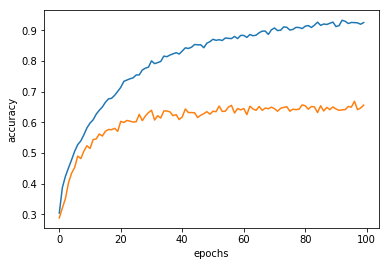

[[174  11   4   4  11  42]
 [  7 135  15  17  19  25]
 [  8  16 175  14  11  12]
 [  3  13  21 133  30  11]
 [  6  19  16  22 134  15]
 [ 28  20   9  22  16 141]]
              precision    recall  f1-score   support

        calm       0.77      0.71      0.74       246
       happy       0.63      0.62      0.62       218
       angry       0.73      0.74      0.74       236
     fearful       0.63      0.63      0.63       211
   surprised       0.61      0.63      0.62       212
         sad       0.57      0.60      0.59       236

    accuracy                           0.66      1359
   macro avg       0.66      0.65      0.66      1359
weighted avg       0.66      0.66      0.66      1359



In [17]:

plt.plot(list(range(0, len(logger.training))), list(map(lambda x:x[1], logger.training)), label="training data")
plt.plot(list(range(0, len(logger.testing))), list(map(lambda x:x[1], logger.testing)), label="testing data")
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
print_metrics(X_test, Y_test, emotion_list)

In this graph we can see that the model largely overfit around the 20st epoch
We can also see that the testing data's accuracy continues to grow.

In [18]:
# Now we save the model so we don't have to retrain it each time
vm.model.save("emotion_lstm-1s.model")

In [37]:
# Here we load the model to check if nothing went wrong
vm.model.load("emotion_lstm-1s.model")

In [19]:
# Now we load the new dataset (savee)

# First we change the folder path
folder_path += "/savee"

# Now we load the data
data = {f: load_wav(f"{folder_path}/{f}", nb_break) for f in emotion_list}
X_savee, Y_savee = preprare_wav(data, vm, sample_duration, step)
X_savee = X_savee.astype('float32')
X_savee_train, X_savee_test, Y_savee_train, Y_savee_test = train_test_split(X_savee, Y_savee, test_size=0.2, random_state=42)

Doing calm
Doing happy
Doing angry
Doing fearful
Doing surprised
Doing sad


In [20]:
vm.model._model.evaluate(X_savee, Y_savee)
print_metrics(X_savee, Y_savee, emotion_list)

2582/2582 [==============================] - 1s 345us/sample - loss: 6.7283 - acc: 0.2029
[[ 88  67 248   4 248  30]
 [ 28  95  72  18 128  27]
 [ 20  52 121   8 146  11]
 [ 35  37  86  18 144  38]
 [ 31  59  53  21 179  20]
 [ 74  63 137   5 148  23]]
              precision    recall  f1-score   support

        calm       0.32      0.13      0.18       685
       happy       0.25      0.26      0.26       368
       angry       0.17      0.34      0.23       358
     fearful       0.24      0.05      0.08       358
   surprised       0.18      0.49      0.26       363
         sad       0.15      0.05      0.08       450

    accuracy                           0.20      2582
   macro avg       0.22      0.22      0.18      2582
weighted avg       0.23      0.20      0.18      2582



In [21]:
# Now we freeze every layer used for extracting features from data
for layer in vm.model._model.layers[:-3]:
    print(layer.name)
    layer.trainable = False
vm.model._model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

gaussian_noise_3
batch_normalization_4
lstm_2
activation_4
flatten_2
batch_normalization_5
gaussian_noise_4


In [22]:
# And we train the two last layers
# This is classic fine tuning
vm.model.train(X_savee_train, Y_savee_train, batch_size=10, validation_data=(X_savee_test, Y_savee_test), epoch=100)

Train on 2065 samples, validate on 517 samples
Epoch 1/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 3.2496 - acc: 0.2581 - val_loss: 2.6290 - val_acc: 0.2766
Epoch 2/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.8056 - acc: 0.3138 - val_loss: 2.1951 - val_acc: 0.3095
Epoch 3/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.6440 - acc: 0.3375 - val_loss: 1.9793 - val_acc: 0.3172
Epoch 4/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5992 - acc: 0.3462 - val_loss: 1.9457 - val_acc: 0.3230
Epoch 5/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5528 - acc: 0.3724 - val_loss: 1.9410 - val_acc: 0.3037
Epoch 6/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5472 - acc: 0.3714 - val_loss: 1.8936 - val_acc: 0.3133
Epoch 7/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5481 - acc: 0.3763 - val_loss: 1.9137 - val_acc: 0

2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5155 - acc: 0.3826 - val_loss: 1.8385 - val_acc: 0.3250
Epoch 61/100
2065/2065 [==============================] - 3s 2ms/sample - loss: 1.5199 - acc: 0.3864 - val_loss: 1.8736 - val_acc: 0.3230
Epoch 62/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5173 - acc: 0.3869 - val_loss: 1.9177 - val_acc: 0.3230
Epoch 63/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5148 - acc: 0.3845 - val_loss: 1.8848 - val_acc: 0.3288
Epoch 64/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5096 - acc: 0.3821 - val_loss: 1.8896 - val_acc: 0.3308
Epoch 65/100
2065/2065 [==============================] - 4s 2ms/sample - loss: 1.5141 - acc: 0.3797 - val_loss: 1.9048 - val_acc: 0.3211
Epoch 66/100
2065/2065 [==============================] - 3s 2ms/sample - loss: 1.5087 - acc: 0.3801 - val_loss: 1.8861 - val_acc: 0.3230
Epoch 67/100
2065/2065 [=======================

In [23]:
print_metrics(X_savee, Y_savee, emotion_list)

[[631   8  14   1  14  17]
 [255  36  34   1  15  27]
 [240  17  66   1  20  14]
 [225  15  22   5  53  38]
 [234  18  28   2  62  19]
 [379   2  19   2  14  34]]
              precision    recall  f1-score   support

        calm       0.32      0.92      0.48       685
       happy       0.38      0.10      0.16       368
       angry       0.36      0.18      0.24       358
     fearful       0.42      0.01      0.03       358
   surprised       0.35      0.17      0.23       363
         sad       0.23      0.08      0.11       450

    accuracy                           0.32      2582
   macro avg       0.34      0.24      0.21      2582
weighted avg       0.34      0.32      0.24      2582

